# Interpretabilidad de modelos ML (SHAP)

Notebook para analizar importancias y explicaciones locales de modelos tradicionales (RandomForest / XGBoost) entrenados con features PSG.



In [10]:
import glob
import json as _json
import os
import sys
import warnings
from datetime import datetime

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from sklearn.inspection import permutation_importance

# Agregar src al path para imports
sys.path.insert(0, os.path.abspath(".."))
from src.models.data_preparation import prepare_train_test_split

# Suprimir warnings de SHAP que no son criticos
warnings.filterwarnings("ignore", category=FutureWarning, module="shap")

# -------------------------
# Config global
# -------------------------
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Submuestreo para SHAP (el dataset es grande)
MAX_SAMPLES = 8000
STRATIFY_SAMPLE = True  # si hay y, intenta muestreo estratificado

# Permutation importance
PERMUTATION_SCORING = "balanced_accuracy"  # alternativa: "accuracy"
PERMUTATION_REPEATS = 10  # repeticiones para reducir varianza

# Configuracion de paths
DATA_PATH = "../data/processed/features_resamp200.parquet"

# Modelos disponibles
# NOTA: Usamos xgb_opt_bayes porque tiene un holdout test set que garantiza
# validez cientifica del analisis SHAP. Los hiperparametros de este modelo
# son los mismos usados en LOSO (los mejores de la optimizacion bayesiana).
MODELS = {
    "xgboost_bayes": "../models/xgb_opt_bayes/xgboost_model.pkl",
    "xgboost_loso": "../models/xgb_loso_best/xgboost_model.pkl",
    "random_forest_bayes": "../models/rf_opt_bayes_best/random_forest_model.pkl",
}
MODEL_NAME = "xgboost_bayes"  # Modelo con holdout test set valido
MODEL_PATH = MODELS[MODEL_NAME]
OUTPUT_DIR = f"../reports/shap_{MODEL_NAME}"

# Parametros del split (deben coincidir con los usados en entrenamiento)
TEST_SIZE = 0.2
VAL_SIZE = 0.2

# Mapeo de etiquetas de sleep staging (AASM standard)
STAGE_LABELS = {0: "W", 1: "N1", 2: "N2", 3: "N3", 4: "REM"}

os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Data: {DATA_PATH}\nModelo: {MODEL_NAME} -> {MODEL_PATH}\nOutput: {OUTPUT_DIR}")

print("=" * 70)

Data: ../data/processed/features_resamp200.parquet
Modelo: xgboost_bayes -> ../models/xgb_opt_bayes/xgboost_model.pkl
Output: ../reports/shap_xgboost_bayes


---

## Justificacion del Modelo Seleccionado

Este analisis usa el modelo **XGBoost con optimizacion bayesiana** (`xgb_opt_bayes`) en lugar del modelo LOSO por las siguientes razones:

1. **Validez cientifica**: El modelo `xgb_opt_bayes` fue entrenado con un split train/val/test **por sujeto**. El test set (20% de sujetos) **nunca fue visto** durante el entrenamiento ni la optimizacion de hiperparametros. Esto garantiza que el analisis SHAP refleja el comportamiento real del modelo sobre datos no vistos.

2. **Mismos hiperparametros**: Los hiperparametros optimos encontrados en la optimizacion bayesiana son los mismos que se usaron para entrenar el modelo LOSO. Por lo tanto, las conclusiones sobre importancia de features son transferibles.

3. **Problema con LOSO**: En validacion cruzada LOSO, el modelo final se re-entrena con **todos los sujetos**. Esto significa que no existe un test set "limpio" - cada sujeto fue usado como test en algun fold, pero el modelo final los vio a todos durante el entrenamiento.



In [11]:
# ------------------------------------------------------------
# Cargar datos y modelo, y recrear el split train/test
# ------------------------------------------------------------

# Cargar features completo
df_full = (
    pd.read_parquet(DATA_PATH)
    if DATA_PATH.endswith(".parquet")
    else pd.read_feather(DATA_PATH)
)

# Ajusta si tu columna de etiqueta se llama distinto
target_col = "stage"

# Cargar modelo
model = joblib.load(MODEL_PATH)
print(f"Modelo: {type(model).__name__}")

# ------------------------------------------------------------
# IMPORTANTE: Recrear el split exacto usado en entrenamiento
# ------------------------------------------------------------
# Usamos los mismos parametros (test_size, val_size, random_state)
# para obtener el MISMO test set que nunca vio el modelo.

print("\nRecreando split train/val/test...")
train_df, test_df, val_df = prepare_train_test_split(
    df_full,
    test_size=TEST_SIZE,
    val_size=VAL_SIZE,
    random_state=RANDOM_STATE,
    stratify_by="subject_core",
    stage_stratify=True,
)

print(f"  Train: {len(train_df):,} epochs")
print(f"  Val:   {len(val_df):,} epochs" if val_df is not None else "  Val: None")
print(f"  Test:  {len(test_df):,} epochs <- USAREMOS ESTE PARA SHAP")

# Verificar sujetos unicos por split
train_subjects = (
    train_df["subject_core"].nunique() if "subject_core" in train_df.columns else "?"
)
test_subjects = (
    test_df["subject_core"].nunique() if "subject_core" in test_df.columns else "?"
)
print(f"\nSujetos unicos - Train: {train_subjects}, Test: {test_subjects}")

# Usar SOLO el test set para el analisis (garantiza validez cientifica)
df = test_df.copy()
print(f"\n[OK] Usando TEST SET ({len(df):,} epochs) para analisis SHAP")

# --- Seleccion de columnas ---
meta_cols = [
    c
    for c in [
        target_col,
        "subject_core",
        "subject_id",
        "epoch_time_start",
        "epoch_index",
    ]
    if c in df.columns
]

# y (etiquetas)
y_raw = df[target_col] if target_col in df.columns else None

# Alinear y al espacio de clases del modelo (evita inconsistencias tipo str vs int)
y = y_raw
MODEL_STAGE_TO_LABEL = None  # stage_str -> model_label (si aplica)
MODEL_LABEL_TO_STAGE = None  # model_label -> stage_str (si aplica)

if (
    y_raw is not None
    and hasattr(model, "classes_")
    and len(getattr(model, "classes_", [])) > 0
):
    model_classes = list(model.classes_)
    cls0 = model_classes[0]

    stage_order_aasm = ["W", "N1", "N2", "N3", "REM"]
    stage_order_alpha = sorted(
        stage_order_aasm
    )  # LabelEncoder típico: orden alfabético
    inv_stage = {v: k for k, v in STAGE_LABELS.items()}

    # Caso típico: y es str y el modelo usa labels numéricas (XGBoost entrenado con LabelEncoder)
    if isinstance(cls0, (int, np.integer)) and y_raw.dtype == object:
        uniques = set(pd.Series(y_raw.dropna().unique()).tolist())
        if uniques and uniques.issubset(set(stage_order_aasm)):
            # No asumimos el orden: puede ser AASM (W,N1,...) o alfabético (N1,N2,N3,REM,W).
            # Lo decidimos luego con un chequeo rápido de accuracy sobre el mismo test set.
            if len(model_classes) == len(stage_order_aasm):
                _map_aasm = dict(zip(stage_order_aasm, model_classes))
                _map_alpha = dict(zip(stage_order_alpha, model_classes))
                # Inicialmente, mapea con AASM; luego se ajusta si hace falta
                y = y_raw.map(_map_aasm)
                MODEL_STAGE_TO_LABEL = _map_aasm
            else:
                # Fallback: ids canonicos 0..4 (solo para evitar crasheos)
                y = y_raw.map(inv_stage)
                MODEL_STAGE_TO_LABEL = inv_stage
                print(
                    "[WARN] model.classes_ no tiene 5 clases; usando mapeo canonico 0..4 como fallback"
                )
        else:
            # intento simple de casteo
            try:
                y = y_raw.astype(int)
                print("[INFO] y se casteo a int para coincidir con el modelo")
            except Exception:
                print(
                    "[WARN] y parece no estar alineado con model.classes_. "
                    "Esto puede invalidar permutation importance / analisis de errores."
                )

    # Caso inverso: y numérico y modelo usa str
    elif (
        isinstance(cls0, str) and y is not None and not pd.api.types.is_object_dtype(y)
    ):
        y = y.astype(str)
        print("[INFO] y se casteo a str para coincidir con el modelo")

# X (features) - primero quita metas; luego filtra no-numericas
feature_cols_raw = [c for c in df.columns if c not in meta_cols]
X_raw = df[feature_cols_raw]

non_numeric = [c for c in X_raw.columns if not pd.api.types.is_numeric_dtype(X_raw[c])]
if non_numeric:
    print(
        f"[WARN] Se excluyen {len(non_numeric)} columnas no-numericas de X (ejemplos): {non_numeric[:10]}"
        + (" ..." if len(non_numeric) > 10 else "")
    )

X = X_raw.drop(columns=non_numeric) if non_numeric else X_raw

# Reemplazar infinitos por NaN (diagnostico)
n_inf = np.isinf(X.select_dtypes(include=[np.number]).values).sum()
if n_inf > 0:
    print(f"[WARN] Se encontraron {n_inf:,} valores infinitos; se reemplazan por NaN")
X = X.replace([np.inf, -np.inf], np.nan)

nan_rows = int(X.isna().any(axis=1).sum())
if nan_rows:
    print(
        f"[WARN] Hay {nan_rows:,} filas con NaN/inf en X. Para SHAP/permutation importance se filtraran filas con NaN cuando sea necesario."
    )

# Alinear el orden de columnas si el modelo lo guarda (evita desajustes silenciosos)
if hasattr(model, "feature_names_in_"):
    model_feats = list(model.feature_names_in_)
    missing = [c for c in model_feats if c not in X.columns]
    extra = [c for c in X.columns if c not in model_feats]

    if missing:
        print(
            f"[WARN] Faltan {len(missing)} features que el modelo espera (ejemplos): {missing[:10]}"
            + (" ..." if len(missing) > 10 else "")
        )
    if extra:
        print(
            f"[INFO] X tiene {len(extra)} columnas extra no usadas por el modelo (ejemplos): {extra[:10]}"
            + (" ..." if len(extra) > 10 else "")
        )

    # Reindexa a las features del modelo (si faltan, quedaran NaN -> se aviso arriba)
    X = X.reindex(columns=model_feats)

# -------------------------
# Resolver encoding correcto (AASM vs LabelEncoder) para y, si aplica
# -------------------------
if (
    y_raw is not None
    and hasattr(model, "classes_")
    and len(getattr(model, "classes_", [])) == 5
    and isinstance(list(model.classes_)[0], (int, np.integer))
    and y_raw.dtype == object
    and set(pd.Series(y_raw.dropna().unique()).tolist()).issubset(
        {"W", "N1", "N2", "N3", "REM"}
    )
    and X is not None
    and MODEL_STAGE_TO_LABEL is not None
    and "_map_alpha" in locals()
):

    def _pred_labels(_m, _X: pd.DataFrame) -> np.ndarray:
        _p = np.asarray(_m.predict(_X))
        if _p.ndim == 2 and _p.shape[1] > 1:
            if (
                hasattr(_m, "classes_")
                and len(getattr(_m, "classes_", [])) == _p.shape[1]
            ):
                return np.asarray(_m.classes_)[_p.argmax(axis=1)]
            return _p.argmax(axis=1)
        return _p

    _X_ok = X.dropna()
    if len(_X_ok) > 0:
        _n = min(2000, len(_X_ok))
        _rng = np.random.default_rng(RANDOM_STATE)
        _idx = _rng.choice(len(_X_ok), size=_n, replace=False)
        _X_chk = _X_ok.iloc[_idx]
        _y_str_chk = y_raw.loc[_X_chk.index]
        _pred = _pred_labels(model, _X_chk)

        _y_aasm = _y_str_chk.map(_map_aasm)
        _y_alpha = _y_str_chk.map(_map_alpha)
        _acc_aasm = (np.asarray(_y_aasm) == _pred).mean()
        _acc_alpha = (np.asarray(_y_alpha) == _pred).mean()

        if _acc_alpha > _acc_aasm + 1e-6:
            y = y_raw.map(_map_alpha)
            MODEL_STAGE_TO_LABEL = _map_alpha
            print(
                "[INFO] Encoding detectado: LabelEncoder (alfabético). y se remapea a labels del modelo."
            )
            print(f"       acc(alpha)={_acc_alpha:.3f} vs acc(aasm)={_acc_aasm:.3f}")
        else:
            y = y_raw.map(_map_aasm)
            MODEL_STAGE_TO_LABEL = _map_aasm
            print(
                "[INFO] Encoding detectado: AASM (W,N1,N2,N3,REM). y se mapea a labels del modelo."
            )
            print(f"       acc(aasm)={_acc_aasm:.3f} vs acc(alpha)={_acc_alpha:.3f}")

# Construir mapping inverso (para imprimir labels correctamente)
if isinstance(MODEL_STAGE_TO_LABEL, dict) and MODEL_STAGE_TO_LABEL:
    try:
        MODEL_LABEL_TO_STAGE = {
            int(v): k for k, v in MODEL_STAGE_TO_LABEL.items() if pd.notna(v)
        }
    except Exception:
        MODEL_LABEL_TO_STAGE = None

feature_cols = list(X.columns)

print(f"\nFeatures shape: {X.shape}")
print(f"Features: {feature_cols[:10]}{'...' if len(feature_cols) > 10 else ''}")

if y is not None:
    class_counts = y.value_counts(dropna=False).sort_index()
    print(f"\nDistribucion de clases ({y.nunique(dropna=True)} clases):")
    for cls, count in class_counts.items():
        # Si el modelo usa ids "raros" (LabelEncoder), preferimos mostrar la etiqueta real
        if MODEL_LABEL_TO_STAGE is not None:
            try:
                label = MODEL_LABEL_TO_STAGE.get(int(cls), str(cls))
            except Exception:
                label = str(cls)
            print(f"  {label} ({cls}): {count:,} ({100*count/len(y):.1f}%)")
        else:
            try:
                cls_int = int(cls) if pd.notna(cls) else None
            except (ValueError, TypeError):
                cls_int = None
            label = STAGE_LABELS.get(cls_int, str(cls))
            print(f"  {label} ({cls}): {count:,} ({100*count/len(y):.1f}%)")
else:
    print(
        "[WARN] No se encontro columna de etiqueta; se omiten secciones dependientes de y"
    )

# Mostrar importancia nativa si esta disponible
if hasattr(model, "feature_importances_"):
    imp_native = pd.DataFrame(
        {"feature": feature_cols, "importance": model.feature_importances_}
    ).sort_values("importance", ascending=False)
    print("\nTop 10 features (importancia nativa - Gini/Gain):")
    print(imp_native.head(10).to_string(index=False))

# --- Muestreo para SHAP/permutation importance ---
# NOTA: Ya estamos usando el test set, asi que el analisis es valido


def _sample_rows(
    X_in: pd.DataFrame,
    y_in: pd.Series | None,
    n: int,
    *,
    stratify: bool,
    random_state: int = RANDOM_STATE,
) -> tuple[pd.DataFrame, pd.Series | None]:
    """Muestrea filas de X e y, filtrando NaN y opcionalmente estratificando."""
    if X_in.isna().any().any():
        X_ok = X_in.dropna()
        if len(X_ok) == 0:
            raise ValueError(
                "X tiene NaNs en todas las filas; no se puede muestrear para SHAP"
            )
        y_ok = y_in.loc[X_ok.index] if y_in is not None else None
        dropped = len(X_in) - len(X_ok)
        if dropped:
            print(f"[INFO] Filtrando {dropped:,} filas con NaN/inf para analisis")
    else:
        X_ok, y_ok = X_in, y_in

    if n >= len(X_ok):
        return X_ok.copy(), y_ok.copy() if y_ok is not None else None

    rng = np.random.default_rng(random_state)

    if stratify and (y_ok is not None) and (y_ok.nunique(dropna=True) > 1):
        n_classes = int(y_ok.nunique(dropna=True))
        per_class = max(1, n // n_classes)
        df_join = X_ok.copy()
        df_join["__y__"] = y_ok

        parts = []
        for _, g in df_join.groupby("__y__"):
            sample_n = min(len(g), per_class)
            idx = rng.choice(len(g), size=sample_n, replace=False)
            parts.append(g.iloc[idx])
        sampled = pd.concat(parts, axis=0)

        if len(sampled) < n:
            remaining = df_join.drop(index=sampled.index)
            if len(remaining) > 0:
                fill_n = min(n - len(sampled), len(remaining))
                fill_idx = rng.choice(len(remaining), size=fill_n, replace=False)
                fill = remaining.iloc[fill_idx]
                sampled = pd.concat([sampled, fill], axis=0)

        sampled = sampled.sample(n=min(n, len(sampled)), random_state=random_state)
        y_s = sampled.pop("__y__")
        return sampled, y_s

    idx = rng.choice(len(X_ok), size=n, replace=False)
    X_s = X_ok.iloc[idx]
    y_s = y_ok.iloc[idx] if y_ok is not None else None
    return X_s, y_s


if len(X) > MAX_SAMPLES:
    X_sample, y_sample = _sample_rows(X, y, MAX_SAMPLES, stratify=STRATIFY_SAMPLE)
    print(
        f"\nUsando submuestra de {len(X_sample):,} para SHAP (de {len(X):,} total en test set)"
    )
else:
    X_sample, y_sample = _sample_rows(X, y, len(X), stratify=False)
    print(f"\nUsando test set completo ({len(X_sample):,} muestras) para SHAP")

print(f"Sample shape: {X_sample.shape}")

# Flag para indicar si permutation importance fue calculado
_permutation_importance_computed = False

Modelo: XGBClassifier

Recreando split train/val/test...
  Train: 112,493 epochs
  Val:   39,933 epochs
  Test:  34,073 epochs <- USAREMOS ESTE PARA SHAP

Sujetos unicos - Train: 48, Test: 15

[OK] Usando TEST SET (34,073 epochs) para analisis SHAP
[INFO] X tiene 1 columnas extra no usadas por el modelo (ejemplos): ['session_idx']
[INFO] Encoding detectado: LabelEncoder (alfabético). y se remapea a labels del modelo.
       acc(alpha)=0.741 vs acc(aasm)=0.073

Features shape: (34073, 133)
Features: [np.str_('EEG Fpz-Cz_rel_delta'), np.str_('EEG Fpz-Cz_abs_delta'), np.str_('EEG Fpz-Cz_rel_theta'), np.str_('EEG Fpz-Cz_abs_theta'), np.str_('EEG Fpz-Cz_rel_alpha'), np.str_('EEG Fpz-Cz_abs_alpha'), np.str_('EEG Fpz-Cz_rel_sigma'), np.str_('EEG Fpz-Cz_abs_sigma'), np.str_('EEG Fpz-Cz_rel_beta'), np.str_('EEG Fpz-Cz_abs_beta')]...

Distribucion de clases (5 clases):
  N1 (0): 4,067 (11.9%)
  N2 (1): 12,560 (36.9%)
  N3 (2): 3,208 (9.4%)
  REM (3): 5,076 (14.9%)
  W (4): 9,162 (26.9%)

Top 10 

In [12]:
# ------------------------------------------------------------
# Validación de compatibilidad modelo-datos
# ------------------------------------------------------------

print("=== VALIDACIÓN DE COMPATIBILIDAD MODELO-DATOS ===\n")

# Guard: esta celda asume que ya corriste la celda anterior (carga/split/feature matrix)
_required = ["MODEL_PATH", "model", "df", "X", "y"]
_missing = [k for k in _required if k not in globals()]
if _missing:
    print(f"[ERROR] Faltan variables: {_missing}")
    print("Ejecuta primero: Celda 2 (config) y luego Celda 4 (cargar datos/split).")
else:
    # Cargar métricas originales del modelo
    _metrics_path = MODEL_PATH.replace("_model.pkl", "_metrics.json")
    _original_accuracy = None
    if os.path.exists(_metrics_path):
        with open(_metrics_path) as _f:
            _metrics = _json.load(_f)
        _original_accuracy = _metrics.get("metrics", {}).get("accuracy")
        print(
            f"Accuracy reportada en entrenamiento: {_original_accuracy:.3f}"
            if _original_accuracy
            else "N/A"
        )
        print(f"Fecha de entrenamiento: {_metrics.get('timestamp', 'N/A')}")

    # Diagnóstico rápido: clases y tipos
    if hasattr(model, "classes_"):
        print(f"model.classes_: {list(model.classes_)}")
    print(f"Test set size (df): {len(df):,}")
    print(f"X shape: {X.shape}")
    if y is not None:
        print(f"y dtype: {y.dtype}")

    # Verificar accuracy actual sobre una muestra pequeña
    _X_clean = X.dropna()
    _dropped = len(X) - len(_X_clean)
    if _dropped:
        print(f"[INFO] Filtrando {_dropped:,} filas con NaN para validación")
    _y_clean = y.loc[_X_clean.index] if y is not None else None

    _data_compatible = True
    if _y_clean is not None and len(_X_clean) > 0:
        _test_n = min(2000, len(_X_clean))
        _rng_test = np.random.default_rng(RANDOM_STATE)
        _test_idx = _rng_test.choice(len(_X_clean), size=_test_n, replace=False)
        _X_test = _X_clean.iloc[_test_idx]
        _y_test = _y_clean.iloc[_test_idx]

        _y_pred_test = model.predict(_X_test)
        _y_pred_arr = np.asarray(_y_pred_test)

        # Robustez: algunos wrappers devuelven matriz (n, k) en predict
        if _y_pred_arr.ndim == 2 and _y_pred_arr.shape[1] > 1:
            if (
                hasattr(model, "classes_")
                and len(getattr(model, "classes_", [])) == _y_pred_arr.shape[1]
            ):
                _y_pred_labels = np.asarray(model.classes_)[_y_pred_arr.argmax(axis=1)]
                print(
                    "[WARN] model.predict devolvió matriz; usando argmax y model.classes_ para labels"
                )
            else:
                _y_pred_labels = _y_pred_arr.argmax(axis=1)
                print(
                    "[WARN] model.predict devolvió matriz; usando argmax (sin mapeo a clases)"
                )
        else:
            _y_pred_labels = _y_pred_arr

        _current_accuracy = (np.asarray(_y_pred_labels) == np.asarray(_y_test)).mean()
        print(
            f"Accuracy actual sobre muestra aleatoria ({_test_n}): {_current_accuracy:.3f}"
        )

        # Evaluar compatibilidad
        if _original_accuracy and abs(_current_accuracy - _original_accuracy) > 0.2:
            _data_compatible = False
            print("\n" + "=" * 60)
            print("[ADVERTENCIA]  ADVERTENCIA: POSIBLE INCOMPATIBILIDAD DE DATOS")
            print("=" * 60)
            print(f"""
La accuracy actual ({_current_accuracy:.1%}) difiere significativamente
de la accuracy original ({_original_accuracy:.1%}).

Posibles causas:
1. El archivo de features fue regenerado con parámetros diferentes
2. La versión de las librerías de extracción cambió
3. Se modificó el preprocesamiento de señales
4. Se desalinearon las clases/encoding (p.ej. 0..4 vs 1..5)

El análisis SHAP sigue siendo válido para explicar cómo el modelo
interpreta estos datos, pero NO refleja el comportamiento real del
modelo entrenado.

RECOMENDACIÓN: Regenerar el modelo con los datos actuales O usar el
dataset de features original.
""")
        elif _current_accuracy > 0.5:
            print("\n[OK] Los datos parecen compatibles con el modelo")
        else:
            _data_compatible = False
            print(
                "\n[ADVERTENCIA]  Accuracy muy baja - revisar compatibilidad de datos"
            )

    print("=" * 60 + "\n")

=== VALIDACIÓN DE COMPATIBILIDAD MODELO-DATOS ===

Accuracy reportada en entrenamiento: 0.730
Fecha de entrenamiento: 2025-12-08T14:38:36.262629
model.classes_: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
Test set size (df): 34,073
X shape: (34073, 133)
y dtype: int64
Accuracy actual sobre muestra aleatoria (2000): 0.741

[OK] Los datos parecen compatibles con el modelo



In [13]:
# ------------------------------------------------------------
# SHAP: explicaciones globales y locales
# ------------------------------------------------------------

# Helpers de labels y clases (robusto a clases no-int)


def _fmt_stage_label(cls) -> str:
    """Formatea una etiqueta de clase a su nombre legible."""
    if pd.isna(cls):
        return "NaN"
    try:
        cls_int = int(cls)
    except (ValueError, TypeError):
        cls_int = None
    if cls_int is not None:
        # Si el modelo usa encoding tipo LabelEncoder, el notebook define MODEL_LABEL_TO_STAGE
        try:
            if (
                "MODEL_LABEL_TO_STAGE" in globals()
                and globals()["MODEL_LABEL_TO_STAGE"]
            ):
                return globals()["MODEL_LABEL_TO_STAGE"].get(cls_int, str(cls))
        except Exception:
            pass
        return STAGE_LABELS.get(cls_int, str(cls))
    return str(cls)


# TreeExplainer es eficiente para RF / XGBoost; intentar probas para interpretabilidad
try:
    explainer = shap.TreeExplainer(model, model_output="probability")
    print("Explainer: TreeExplainer con output=probability")
    print(
        "  (Los SHAP values representan contribuciones a la probabilidad de cada clase)"
    )
except Exception as e:
    print(
        f"[WARN] TreeExplainer(probability) falló ({e}); usando TreeExplainer por defecto"
    )
    explainer = shap.TreeExplainer(model)
    print("  (Los SHAP values representan contribuciones al log-odds o margin)")

shap_values = explainer.shap_values(X_sample)

# Detectar formato de shap_values (lista para multi-clase en SHAP antiguo, o array 3D en SHAP nuevo)
is_multiclass_list = isinstance(shap_values, list)
is_multiclass_3d = isinstance(shap_values, np.ndarray) and shap_values.ndim == 3

n_classes = (
    len(shap_values)
    if is_multiclass_list
    else (shap_values.shape[2] if is_multiclass_3d else 1)
)
print(
    f"SHAP values calculados. Multi-clase: {is_multiclass_list or is_multiclass_3d} ({n_classes} clases)"
)

# Determinar clases del modelo (si existen) y su orden
model_classes = list(getattr(model, "classes_", []))
if model_classes and len(model_classes) == n_classes:
    class_values = model_classes
else:
    class_values = list(range(n_classes))

class_to_index = {cls: i for i, cls in enumerate(class_values)}

print(
    "Clases del modelo (orden): "
    + ", ".join([f"{_fmt_stage_label(c)} ({c})" for c in class_values])
)


def _choose_main_class_label():
    """Clase principal para plots (moda de y_sample si existe; si no, predicción)."""
    if y_sample is not None and len(y_sample) > 0:
        mode_val = y_sample.mode(dropna=True)
        if len(mode_val) > 0:
            return mode_val.iloc[0]
    try:
        return model.predict(X_sample.iloc[[0]])[0]
    except Exception:
        return class_values[0]


main_class_label = _choose_main_class_label()
main_class_index = class_to_index.get(main_class_label, 0)
print(
    f"Clase principal para plots: {_fmt_stage_label(main_class_label)} ({main_class_label}) [idx={main_class_index}]"
)


def _mean_abs_shap(shap_vals) -> np.ndarray:
    """Calcula mean(|SHAP|) agregado sobre todas las clases para ranking global."""
    if isinstance(shap_vals, list):
        # lista de (n_samples, n_features) por clase -> promedio entre clases
        return np.mean([np.abs(sv) for sv in shap_vals], axis=0)
    elif isinstance(shap_vals, np.ndarray) and shap_vals.ndim == 3:
        # (n_samples, n_features, n_classes) -> promedio entre clases
        return np.mean(np.abs(shap_vals), axis=2)
    return np.abs(shap_vals)


shap_abs = _mean_abs_shap(shap_values)

# ------------------------------------------------------------
# IMPORTANTE (validez científica): agregación por sujeto
# ------------------------------------------------------------
# Los epochs dentro de un sujeto están correlacionados; si promediamos por epoch,
# sujetos con más epochs dominan el ranking. Para evitarlo, agregamos primero por sujeto
# (mean(|SHAP|) por sujeto) y luego promediamos entre sujetos (peso igual por sujeto).

mean_abs_epoch = shap_abs.mean(axis=0)  # referencia (ponderado por epoch)
mean_abs_subject = None

if "subject_core" in df.columns:
    subj = df.loc[X_sample.index, "subject_core"].astype(str)
    shap_df = pd.DataFrame(shap_abs, columns=feature_cols)
    subj_means = shap_df.groupby(subj.to_numpy()).mean()  # (n_subjects, n_features)
    mean_abs_subject = subj_means.mean(axis=0).to_numpy()
    mean_abs = mean_abs_subject
    print(
        f"[INFO] SHAP global agregado por sujeto: {subj_means.shape[0]} sujetos (peso igual por sujeto)"
    )
else:
    mean_abs = mean_abs_epoch
    print(
        "[WARN] No hay 'subject_core'; usando agregado por epoch (puede sesgar por sujetos con más epochs)"
    )

top_idx = np.argsort(mean_abs)[::-1]

# Mostrar ranking de features
print(
    "\nTop 15 features por SHAP (mean|SHAP| agregado multi-clase, ponderación por sujeto si es posible):"
)
for rank, idx in enumerate(top_idx[:15], 1):
    print(f"  {rank:2d}. {feature_cols[idx]}: {mean_abs[idx]:.4f}")

[WARN] TreeExplainer(probability) falló (Only model_output="raw" is supported for feature_perturbation="tree_path_dependent"); usando TreeExplainer por defecto
  (Los SHAP values representan contribuciones al log-odds o margin)
SHAP values calculados. Multi-clase: True (5 clases)
Clases del modelo (orden): N1 (0), N2 (1), N3 (2), REM (3), W (4)
Clase principal para plots: N1 (0) [idx=0]
[INFO] SHAP global agregado por sujeto: 15 sujetos (peso igual por sujeto)

Top 15 features por SHAP (mean|SHAP| agregado multi-clase, ponderación por sujeto si es posible):
   1. EEG Fpz-Cz_abs_delta: 0.3950
   2. EEG Fpz-Cz_rel_gamma: 0.2120
   3. EEG Fpz-Cz_slow_wave_power: 0.1686
   4. EOG horizontal_abs_gamma: 0.1675
   5. EEG Pz-Oz_abs_delta: 0.1499
   6. EMG submental_mean: 0.1309
   7. EOG horizontal_abs_beta: 0.1299
   8. EEG Fpz-Cz_slow_wave_ratio: 0.1166
   9. EEG Fpz-Cz_rel_theta: 0.1133
  10. EEG Fpz-Cz_spectral_entropy: 0.1116
  11. EOG horizontal_abs_alpha: 0.1084
  12. EEG Fpz-Cz_rel_bet

/var/folders/d7/n172hp1122v4b5zh7wykndlr0000gn/T/ipykernel_70919/2970734602.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False, max_display=20)


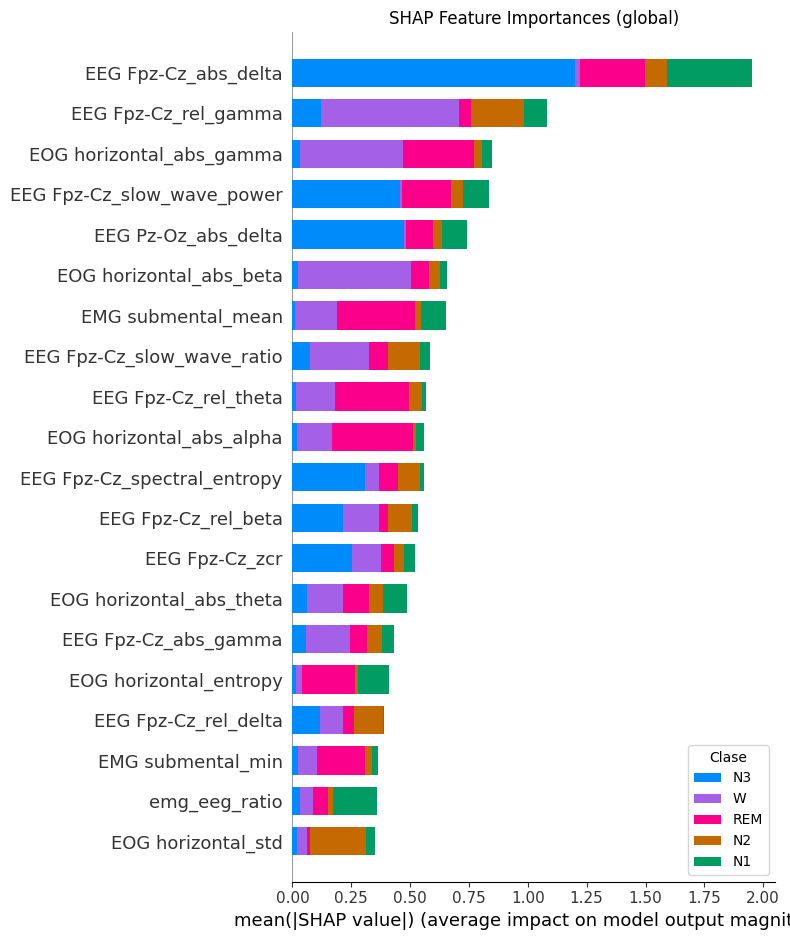

In [14]:
# ------------------------------------------------------------
# SHAP: Plots globales (bar)
# ------------------------------------------------------------

# Summary bar (importancias globales)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False, max_display=20)

# Renombrar leyenda "Class k" -> etiqueta de etapa (si aplica)
try:
    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    if labels and all(lbl.startswith("Class ") for lbl in labels):
        label_map = {
            f"Class {i}": _fmt_stage_label(class_values[i])
            for i in range(min(len(labels), len(class_values)))
        }
        ax.legend(handles, [label_map.get(lbl, lbl) for lbl in labels], title="Clase")
except Exception:
    pass

plt.title("SHAP Feature Importances (global)")
plt.tight_layout()
plt.savefig(
    os.path.join(OUTPUT_DIR, "shap_importances_bar.png"),
    dpi=150,
    bbox_inches="tight",
)
plt.show()

/var/folders/d7/n172hp1122v4b5zh7wykndlr0000gn/T/ipykernel_70919/3132310665.py:28: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv_class, X_sample, show=False, max_display=10, plot_size=None)
/var/folders/d7/n172hp1122v4b5zh7wykndlr0000gn/T/ipykernel_70919/3132310665.py:28: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv_class, X_sample, show=False, max_display=10, plot_size=None)
/var/folders/d7/n172hp1122v4b5zh7wykndlr0000gn/T/ipykernel_70919/3132310665.py:28: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the gl

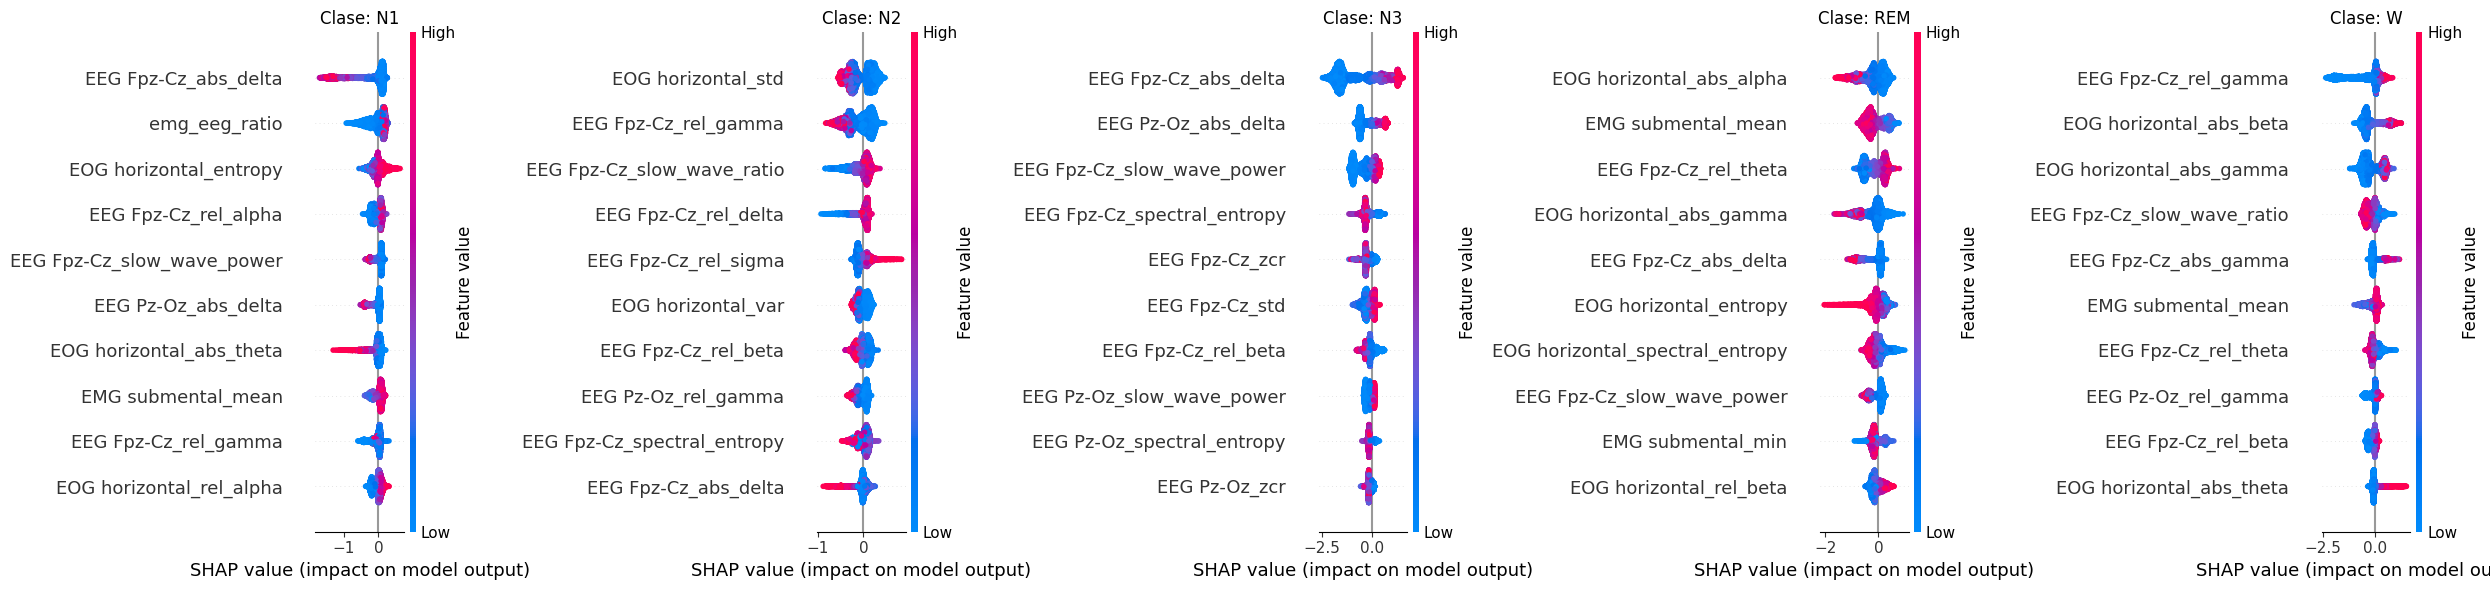


Top 5 features más importantes por clase:
------------------------------------------------------------
N1: EEG Fpz-Cz_abs_delta, emg_eeg_ratio, EOG horizontal_entropy, EEG Fpz-Cz_rel_alpha, EEG Fpz-Cz_slow_wave_power
N2: EOG horizontal_std, EEG Fpz-Cz_rel_gamma, EEG Fpz-Cz_slow_wave_ratio, EEG Fpz-Cz_rel_delta, EEG Fpz-Cz_rel_sigma
N3: EEG Fpz-Cz_abs_delta, EEG Pz-Oz_abs_delta, EEG Fpz-Cz_slow_wave_power, EEG Fpz-Cz_spectral_entropy, EEG Fpz-Cz_zcr
REM: EOG horizontal_abs_alpha, EMG submental_mean, EEG Fpz-Cz_rel_theta, EOG horizontal_abs_gamma, EEG Fpz-Cz_abs_delta
W: EEG Fpz-Cz_rel_gamma, EOG horizontal_abs_beta, EOG horizontal_abs_gamma, EEG Fpz-Cz_slow_wave_ratio, EEG Fpz-Cz_abs_gamma


In [15]:
# ------------------------------------------------------------
# SHAP por clase: análisis específico para cada etapa del sueño
# ------------------------------------------------------------

# Crear beeswarm para cada clase (importante para entender qué features discriminan cada etapa)
# Nota: algunas versiones de SHAP pueden crear figuras separadas aunque uses subplots.

n_classes_to_plot = min(n_classes, 5)  # limitar si hay muchas clases

fig, axes = plt.subplots(1, n_classes_to_plot, figsize=(5 * n_classes_to_plot, 6))
if n_classes_to_plot == 1:
    axes = [axes]

for class_index in range(n_classes_to_plot):
    plt.sca(axes[class_index])
    class_value = (
        class_values[class_index] if class_index < len(class_values) else class_index
    )
    class_label = _fmt_stage_label(class_value)

    if is_multiclass_list:
        sv_class = shap_values[class_index]
    elif is_multiclass_3d:
        sv_class = shap_values[:, :, class_index]
    else:
        sv_class = shap_values

    shap.summary_plot(sv_class, X_sample, show=False, max_display=10, plot_size=None)
    axes[class_index].set_title(f"Clase: {class_label}")

plt.tight_layout()
plt.savefig(
    os.path.join(OUTPUT_DIR, "shap_beeswarm_by_class.png"),
    dpi=150,
    bbox_inches="tight",
)
plt.show()

# Tabla: Top 5 features por clase
print("\nTop 5 features más importantes por clase:")
print("-" * 60)
for class_index in range(n_classes):
    class_value = (
        class_values[class_index] if class_index < len(class_values) else class_index
    )
    class_label = _fmt_stage_label(class_value)

    if is_multiclass_list:
        sv_class = shap_values[class_index]
    elif is_multiclass_3d:
        sv_class = shap_values[:, :, class_index]
    else:
        sv_class = shap_values

    mean_abs_class = np.abs(sv_class).mean(axis=0)
    top5_idx = np.argsort(mean_abs_class)[::-1][:5]
    top5_features = [feature_cols[i] for i in top5_idx]
    print(f"{class_label}: {', '.join(top5_features)}")

Calculando permutation importance (puede tardar)...
  - Scoring: balanced_accuracy
  - Repeticiones: 10
[INFO] PI sobre muestra balanceada por sujeto: 750 epochs (max 50/sujeto, n_sujetos=15)


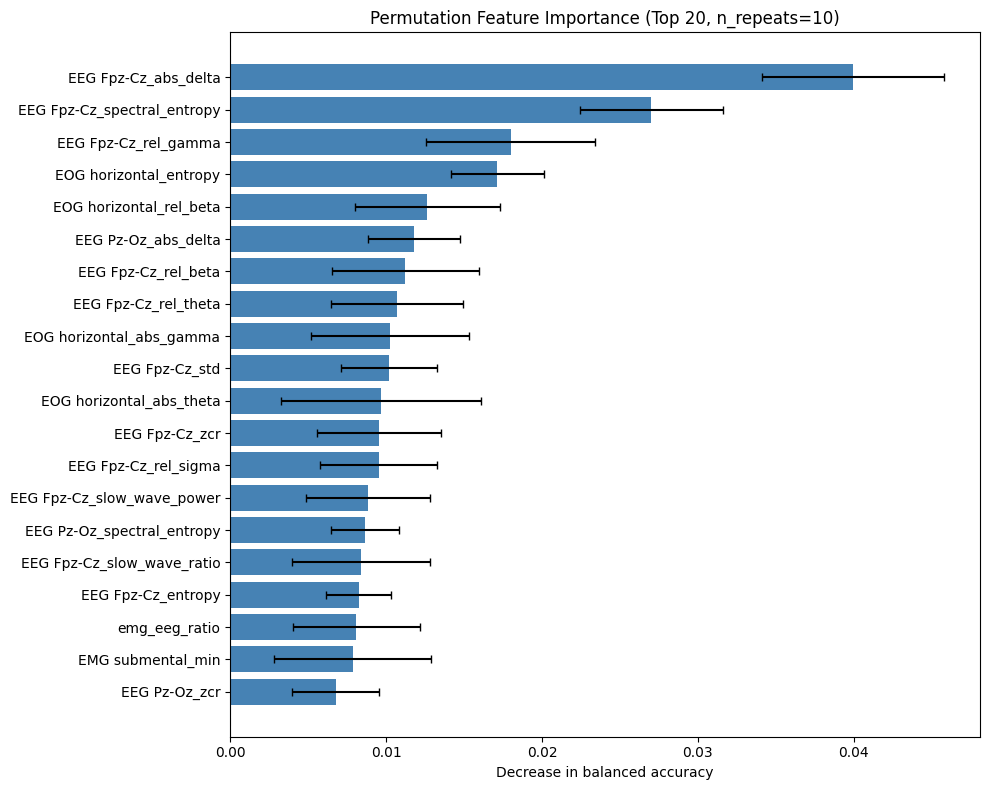


Top 10 features (permutation importance):
                    feature  importance_mean  importance_std    ci_95
       EEG Fpz-Cz_abs_delta         0.039964        0.005849 0.003625
EEG Fpz-Cz_spectral_entropy         0.027004        0.004583 0.002840
       EEG Fpz-Cz_rel_gamma         0.017985        0.005393 0.003343
     EOG horizontal_entropy         0.017126        0.002979 0.001847
    EOG horizontal_rel_beta         0.012656        0.004669 0.002894
        EEG Pz-Oz_abs_delta         0.011764        0.002948 0.001827
        EEG Fpz-Cz_rel_beta         0.011236        0.004704 0.002916
       EEG Fpz-Cz_rel_theta         0.010685        0.004224 0.002618
   EOG horizontal_abs_gamma         0.010261        0.005069 0.003142
             EEG Fpz-Cz_std         0.010177        0.003084 0.001911

Features con importancia significativa (mean > 2*std): 20


In [16]:
# ------------------------------------------------------------
# Permutation importance (model-agnostic)
# ------------------------------------------------------------

# Variable global para tracking
pi = None  # Inicializar para evitar NameError en celdas posteriores

if y_sample is not None:
    print("Calculando permutation importance (puede tardar)...")
    print(f"  - Scoring: {PERMUTATION_SCORING}")
    print(f"  - Repeticiones: {PERMUTATION_REPEATS}")

    # --------------------------------------------------------
    # IMPORTANTE (validez científica): balancear por sujeto
    # --------------------------------------------------------
    # PI asume muestras i.i.d. y puede quedar dominada por sujetos con más epochs.
    # Para mitigar, tomamos una submuestra con máximo N epochs por sujeto.
    X_pi, y_pi = X_sample, y_sample
    if "subject_core" in df.columns:
        subj = df.loc[X_sample.index, "subject_core"].astype(str)
        rng_pi = np.random.default_rng(RANDOM_STATE)
        max_per_subject = 50
        chosen_idx = []
        groups = subj.groupby(subj).groups  # subject -> indices
        for _, idxs in groups.items():
            idxs = np.array(list(idxs))
            take = min(len(idxs), max_per_subject)
            sel = rng_pi.choice(idxs, size=take, replace=False)
            chosen_idx.extend(sel.tolist())
        chosen_idx = pd.Index(chosen_idx)
        X_pi = X_sample.loc[chosen_idx]
        y_pi = y_sample.loc[chosen_idx]
        print(
            f"[INFO] PI sobre muestra balanceada por sujeto: {len(chosen_idx):,} epochs "
            f"(max {max_per_subject}/sujeto, n_sujetos={len(groups):,})"
        )

    pi = permutation_importance(
        model,
        X_pi,
        y_pi,
        n_repeats=PERMUTATION_REPEATS,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        scoring=PERMUTATION_SCORING,
    )

    _permutation_importance_computed = True

    pi_df = pd.DataFrame(
        {
            "feature": feature_cols,
            "importance_mean": pi.importances_mean,
            "importance_std": pi.importances_std,
        }
    ).sort_values("importance_mean", ascending=False)

    # Calcular intervalo de confianza al 95% (aprox. ±1.96*std/sqrt(n))
    pi_df["ci_95"] = 1.96 * pi_df["importance_std"] / np.sqrt(PERMUTATION_REPEATS)

    pi_df.to_csv(os.path.join(OUTPUT_DIR, "permutation_importance.csv"), index=False)

    # Visualizar top 20
    top_pi = pi_df.head(20)
    plt.figure(figsize=(10, 8))
    plt.barh(
        range(len(top_pi)),
        top_pi["importance_mean"],
        xerr=top_pi["importance_std"],
        color="steelblue",
        capsize=3,
    )
    plt.yticks(range(len(top_pi)), top_pi["feature"])
    plt.xlabel(f"Decrease in {PERMUTATION_SCORING.replace('_', ' ')}")
    plt.title(
        f"Permutation Feature Importance (Top 20, n_repeats={PERMUTATION_REPEATS})"
    )
    plt.gca().invert_yaxis()
    plt.axvline(x=0, color="gray", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(
        os.path.join(OUTPUT_DIR, "permutation_importance.png"),
        dpi=150,
        bbox_inches="tight",
    )
    plt.show()

    print("\nTop 10 features (permutation importance):")
    print(
        pi_df[["feature", "importance_mean", "importance_std", "ci_95"]]
        .head(10)
        .to_string(index=False)
    )

    # Identificar features con importancia significativamente > 0
    significant = pi_df[pi_df["importance_mean"] > 2 * pi_df["importance_std"]]
    print(
        f"\nFeatures con importancia significativa (mean > 2*std): {len(significant)}"
    )
else:
    print("[WARN] No se encontró columna de etiqueta; se omite permutation importance")
    _permutation_importance_computed = False

### Nota sobre discrepancias entre métodos

Es común observar discrepancias entre SHAP, importancia nativa (Gini/Gain) y Permutation Importance:

1. **SHAP vs Native (Gini/Gain)**: Generalmente correlacionados (ρ > 0.7) porque ambos miden contribución al modelo
2. **SHAP/Native vs Permutation**: Pueden diferir significativamente porque:
   - **Permutation Importance** mide el impacto en *performance* al permutar features
   - Si features están correlacionadas, permutar una no afecta mucho porque otra compensa
   - Features con alta importancia SHAP pero baja PI sugieren redundancia/correlación

**Interpretación práctica:**
- Features con alta importancia en TODOS los métodos → evidencia robusta
- Features solo importantes en SHAP/Native → posible redundancia con otras features
- Features solo importantes en Permutation → su efecto es único y no compensable

Importancia SHAP por grupo de features:
                   sum    mean  std_within_group  count
group                                                  
Spectral_Power  1.7314  0.0721            0.0838     24
EOG             1.4800  0.0448            0.0373     33
EMG             0.4972  0.0171            0.0295     29
Slow_Waves      0.4389  0.0731            0.0588      6
Entropy         0.2222  0.0555            0.0402      4
Statistical     0.1704  0.0142            0.0168     12
Zero_Crossing   0.1495  0.0748            0.0404      2
Spectral_Ratio  0.1471  0.0245            0.0184      6
Spindles        0.0417  0.0052            0.0062      8
Dominant_Freq   0.0184  0.0092            0.0067      2
Connectivity    0.0000  0.0000               NaN      1
Hjorth          0.0000  0.0000            0.0000      6


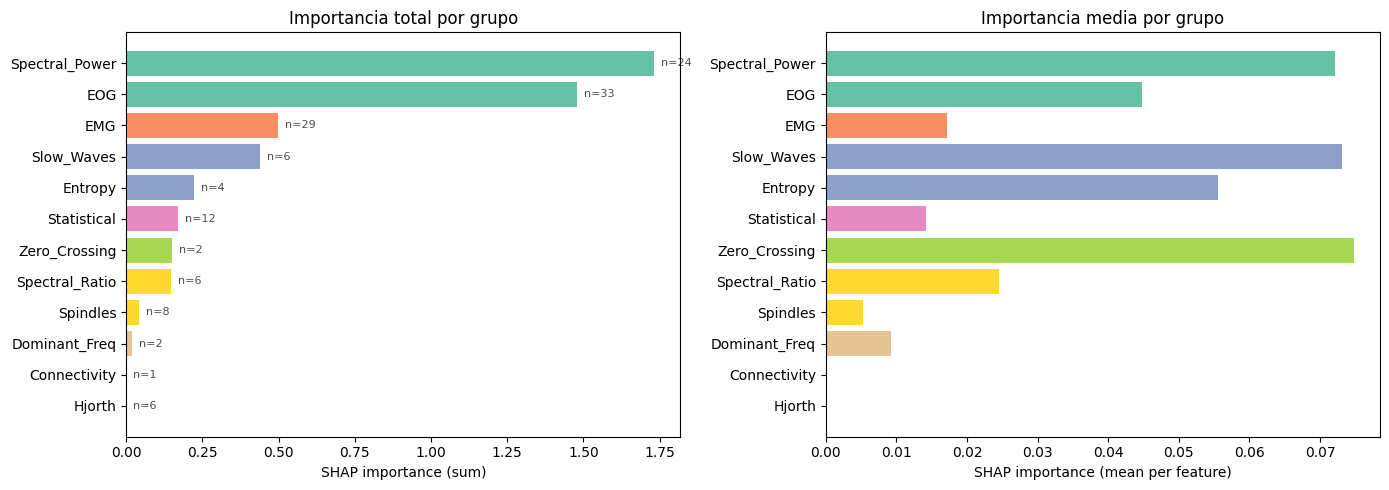


Distribución de features por grupo:
group
EOG               33
EMG               29
Spectral_Power    24
Statistical       12
Spindles           8
Spectral_Ratio     6
Hjorth             6
Slow_Waves         6
Entropy            4
Dominant_Freq      2
Zero_Crossing      2
Connectivity       1

Top 3 features por grupo:
  Spectral_Power: EEG Fpz-Cz_abs_delta, EEG Fpz-Cz_rel_gamma, EEG Pz-Oz_abs_delta
  EOG: EOG horizontal_abs_gamma, EOG horizontal_abs_beta, EOG horizontal_abs_alpha
  EMG: EMG submental_mean, EMG submental_min, emg_eeg_ratio
  Slow_Waves: EEG Fpz-Cz_slow_wave_power, EEG Fpz-Cz_slow_wave_ratio, EEG Pz-Oz_slow_wave_power
  Entropy: EEG Fpz-Cz_spectral_entropy, EEG Fpz-Cz_entropy, EEG Pz-Oz_spectral_entropy
  Statistical: EEG Fpz-Cz_std, EEG Fpz-Cz_var, EEG Fpz-Cz_min
  Zero_Crossing: EEG Fpz-Cz_zcr, EEG Pz-Oz_zcr
  Spectral_Ratio: EEG Fpz-Cz_alpha_delta_ratio, EEG Pz-Oz_alpha_delta_ratio, EEG Fpz-Cz_theta_delta_ratio
  Spindles: EEG Fpz-Cz_spindle_mean_amplitude, EEG Pz-O

In [17]:
# ------------------------------------------------------------
# Importancia por grupos de features
# ------------------------------------------------------------


def categorize_feature(fname: str) -> str:
    """
    Categoriza features PSG basándose en convenciones de nomenclatura estándar.

    Categorías basadas en:
    - Canales: EEG (Fpz-Cz, Pz-Oz), EOG, EMG
    - Tipo de feature: espectral (bandas), temporal (stats), entropía, Hjorth, etc.

    Ajustar patrones según los nombres específicos de features en el dataset.
    """
    fname_lower = fname.lower()

    # Primero detectar por canal (más específico)
    if "eog" in fname_lower or "eye" in fname_lower:
        return "EOG"
    elif "emg" in fname_lower or "chin" in fname_lower:
        return "EMG"

    # Luego por tipo de feature (para EEG y general)
    if any(
        band in fname_lower
        for band in ["delta", "theta", "alpha", "beta", "gamma", "sigma"]
    ):
        if "ratio" in fname_lower:
            return "Spectral_Ratio"
        return "Spectral_Power"
    elif "spindle" in fname_lower:
        return "Spindles"
    elif "slow_wave" in fname_lower or "sw_" in fname_lower:
        return "Slow_Waves"
    elif any(
        temp in fname_lower for temp in ["hjorth", "mobility", "complexity", "activity"]
    ):
        return "Hjorth"
    elif any(
        ent in fname_lower
        for ent in ["entropy", "perm_ent", "sample_ent", "approx_ent", "spectral_ent"]
    ):
        return "Entropy"
    elif any(
        stat in fname_lower
        for stat in [
            "_mean",
            "_std",
            "_var",
            "_skew",
            "_kurt",
            "_rms",
            "_range",
            "_min",
            "_max",
        ]
    ):
        return "Statistical"
    elif "zcr" in fname_lower or "zero_cross" in fname_lower:
        return "Zero_Crossing"
    elif "dominant_freq" in fname_lower:
        return "Dominant_Freq"
    elif any(
        conn in fname_lower
        for conn in ["coherence", "correlation", "plv", "pli", "corr_"]
    ):
        return "Connectivity"
    else:
        return "Other"


# Asignar categorías
feature_groups = pd.DataFrame(
    {
        "feature": feature_cols,
        "group": [categorize_feature(f) for f in feature_cols],
        "shap_importance": mean_abs,
    }
)

# Importancia agregada por grupo
group_importance = (
    feature_groups.groupby("group")["shap_importance"]
    .agg(["sum", "mean", "std", "count"])
    .rename(columns={"std": "std_within_group"})
)
group_importance = group_importance.sort_values("sum", ascending=False)

print("Importancia SHAP por grupo de features:")
print(group_importance.round(4).to_string())

# Visualizar
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Importancia total por grupo
ax1 = axes[0]
n_groups = len(group_importance)
colors = plt.cm.Set2(np.linspace(0, 1, n_groups))
bars1 = ax1.barh(range(n_groups), group_importance["sum"], color=colors)
ax1.set_yticks(range(n_groups))
ax1.set_yticklabels(group_importance.index)
ax1.set_xlabel("SHAP importance (sum)")
ax1.set_title("Importancia total por grupo")
ax1.invert_yaxis()

# Añadir count como anotación
for i, (_, row) in enumerate(group_importance.iterrows()):
    ax1.annotate(
        f"n={int(row['count'])}",
        xy=(row["sum"], i),
        xytext=(5, 0),
        textcoords="offset points",
        va="center",
        fontsize=8,
        alpha=0.7,
    )

# Importancia media por grupo (más justo para comparar grupos de distinto tamaño)
ax2 = axes[1]
ax2.barh(range(n_groups), group_importance["mean"], color=colors)
ax2.set_yticks(range(n_groups))
ax2.set_yticklabels(group_importance.index)
ax2.set_xlabel("SHAP importance (mean per feature)")
ax2.set_title("Importancia media por grupo")
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig(
    os.path.join(OUTPUT_DIR, "shap_by_feature_group.png"), dpi=150, bbox_inches="tight"
)
plt.show()

# Distribución de grupos
print("\nDistribución de features por grupo:")
group_counts = feature_groups["group"].value_counts()
print(group_counts.to_string())

# Top features por grupo
print("\nTop 3 features por grupo:")
for group in group_importance.index:
    group_feats = feature_groups[feature_groups["group"] == group].nlargest(
        3, "shap_importance"
    )
    feat_list = ", ".join(group_feats["feature"].tolist())
    print(f"  {group}: {feat_list}")

In [18]:
# ------------------------------------------------------------
# Resumen del análisis y metadatos
# ------------------------------------------------------------

print("=" * 70)
print("RESUMEN DEL ANÁLISIS DE INTERPRETABILIDAD")
print("=" * 70)

# Metadatos
print(f"\nFecha: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print(f"Modelo: {type(model).__name__}")
print(f"Dataset: {DATA_PATH}")
print(f"Output: {OUTPUT_DIR}")
print(f"N muestras para SHAP: {len(X_sample):,}")
print(f"N features: {len(feature_cols)}")
print(f"N clases: {n_classes}")

# Versiones (para reproducibilidad)
try:
    import sklearn

    sklearn_ver = sklearn.__version__
except Exception:
    sklearn_ver = "?"

try:
    import xgboost

    xgb_ver = xgboost.__version__
except Exception:
    xgb_ver = "N/A"

print("\n--- VERSIONES ---")
print(f"numpy: {np.__version__}")
print(f"pandas: {pd.__version__}")
print(f"shap: {shap.__version__}")
print(f"sklearn: {sklearn_ver}")
print(f"xgboost: {xgb_ver}")

# Clases
print("\n--- CLASES (orden) ---")
print(", ".join([f"{_fmt_stage_label(c)} ({c})" for c in class_values]))

# Top features global
print("\n--- TOP 10 FEATURES (SHAP global agregado) ---")
for rank, idx in enumerate(top_idx[:10], 1):
    print(f"  {rank:2d}. {feature_cols[idx]} (importance: {mean_abs[idx]:.4f})")

# Features más importantes por clase
print("\n--- FEATURES CLAVE POR CLASE (Top 3) ---")
for class_index in range(n_classes):
    class_value = (
        class_values[class_index] if class_index < len(class_values) else class_index
    )
    class_label = _fmt_stage_label(class_value)

    if is_multiclass_list:
        sv_class = shap_values[class_index]
    elif is_multiclass_3d:
        sv_class = shap_values[:, :, class_index]
    else:
        sv_class = shap_values

    mean_abs_class = np.abs(sv_class).mean(axis=0)
    top3_idx = np.argsort(mean_abs_class)[::-1][:3]
    top3_features = [feature_cols[i] for i in top3_idx]
    print(f"  {class_label}: {', '.join(top3_features)}")

# Archivos generados
print("\n--- ARCHIVOS GENERADOS ---")
output_files = sorted(glob.glob(os.path.join(OUTPUT_DIR, "*")))
for f in output_files:
    print(f"  {os.path.basename(f)}")

# Limitaciones - ver celda markdown siguiente

print("=" * 70)
print("Análisis completado. Revisa los plots y CSVs en:", OUTPUT_DIR)
print("=" * 70)

RESUMEN DEL ANÁLISIS DE INTERPRETABILIDAD

Fecha: 2025-12-12 12:22
Modelo: XGBClassifier
Dataset: ../data/processed/features_resamp200.parquet
Output: ../reports/shap_xgboost_bayes
N muestras para SHAP: 8,000
N features: 133
N clases: 5

--- VERSIONES ---
numpy: 2.3.5
pandas: 2.3.3
shap: 0.50.0
sklearn: 1.7.2
xgboost: 3.1.2

--- CLASES (orden) ---
N1 (0), N2 (1), N3 (2), REM (3), W (4)

--- TOP 10 FEATURES (SHAP global agregado) ---
   1. EEG Fpz-Cz_abs_delta (importance: 0.3950)
   2. EEG Fpz-Cz_rel_gamma (importance: 0.2120)
   3. EEG Fpz-Cz_slow_wave_power (importance: 0.1686)
   4. EOG horizontal_abs_gamma (importance: 0.1675)
   5. EEG Pz-Oz_abs_delta (importance: 0.1499)
   6. EMG submental_mean (importance: 0.1309)
   7. EOG horizontal_abs_beta (importance: 0.1299)
   8. EEG Fpz-Cz_slow_wave_ratio (importance: 0.1166)
   9. EEG Fpz-Cz_rel_theta (importance: 0.1133)
  10. EEG Fpz-Cz_spectral_entropy (importance: 0.1116)

--- FEATURES CLAVE POR CLASE (Top 3) ---
  N1: EEG Fpz-Cz_a

---

### Limitaciones y Consideraciones

1. **Validez del test set**: Los valores SHAP se calcularon sobre el holdout test set (20% de sujetos), garantizando que el modelo nunca vio estos datos durante el entrenamiento.

2. **Dependencia intra-sujeto (epochs no i.i.d.)**: Los epochs dentro de un mismo sujeto están correlacionados. Para mejorar la validez del ranking global:
   - La importancia global SHAP se agrega **por sujeto** (promedio por sujeto y luego promedio entre sujetos).
   - La estabilidad por bootstrap se calcula con **cluster bootstrap por sujeto** (muestreo de sujetos con reemplazo).

3. **Transferibilidad a LOSO**: Los hiperparametros de este modelo (xgb_opt_bayes) son identicos a los usados en la validacion LOSO. Por lo tanto, las importancias de features identificadas aqui son representativas del comportamiento del modelo LOSO (misma familia/hiperparámetros), pero el set de entrenamiento final difiere.

4. **Importancia nativa (Gini/Gain) vs SHAP**: Pueden diferir porque:
   - SHAP considera interacciones entre features
   - Gini/Gain puede sobre-representar features con alta cardinalidad

5. **Permutation importance**: Puede subestimar features correlacionadas (cuando se permuta una, otra puede compensar). Aquí se usa una submuestra **balanceada por sujeto** para mitigar sesgos por cantidad de epochs.

6. **Granularidad por sujeto**: El split respeta sujetos completos - todos los epochs de un sujeto estan en train O en test, nunca mezclados. Esto evita data leakage temporal.

---

## Informe de Resultados

### 1) Setup y alcance del análisis

- **Dataset**: `../data/processed/features_resamp200.parquet`
- **Modelo analizado**: `xgboost_bayes` (`../models/xgb_opt_bayes/xgboost_model.pkl`) — `XGBClassifier`
- **Objetivo**: explicar qué features (PSG) impulsan las predicciones del modelo mediante SHAP (global/local) y validar robustez con Permutation Importance.
- **Nota técnica (SHAP / escala)**: en esta corrida `TreeExplainer(model_output="probability")` falló y SHAP se calculó con el explainer por defecto; por eso los SHAP values representan contribuciones al *output interno* del modelo (margin / log-odds aprox.), **no** son “cambios de probabilidad”. El **ranking** (mean(|SHAP|)) sigue siendo útil para comparar importancia relativa de features, pero la magnitud no debe interpretarse como probabilidad.

### 2) Partición usada

El notebook reconstruye el **mismo split por sujeto** utilizado en entrenamiento para mantener un test set “limpio” (no visto):

- **Train**: 112,493 epochs (48 sujetos)
- **Val**: 39,933 epochs
- **Test (usado para SHAP/PI)**: 34,073 epochs (15 sujetos)

Esto es importante porque evita leakage por mezclar epochs de un mismo sujeto entre splits.

### 3) Chequeo de compatibilidad modelo–datos

Se comparó la accuracy reportada en entrenamiento con una estimación actual en una muestra del test set:

- Accuracy reportada en entrenamiento: **0.730**
- Accuracy actual (muestra aleatoria de 2,000 del test): **0.741**
- `model.classes_`: `[0, 1, 2, 3, 4]` con mapeo (orden del modelo): **N1 (0), N2 (1), N3 (2), REM (3), W (4)**
- Matriz de features: **34,073 × 133**

**Conclusión**: los datos parecen **compatibles** con el modelo, por lo que las explicaciones SHAP/PI son interpretables como comportamiento real del modelo sobre datos no vistos.

### 4) Hallazgos globales (SHAP)

Se calculó SHAP y se reportó un ranking global usando **mean(|SHAP|)** con **agregación por sujeto** (peso igual por sujeto) para evitar que sujetos con más epochs dominen el ranking.

**Top 15 features por SHAP (mean|SHAP| agregado, multi-clase):**
1. `EEG Fpz-Cz_abs_delta` (0.3950)
2. `EEG Fpz-Cz_rel_gamma` (0.2120)
3. `EEG Fpz-Cz_slow_wave_power` (0.1686)
4. `EOG horizontal_abs_gamma` (0.1675)
5. `EEG Pz-Oz_abs_delta` (0.1499)
6. `EMG submental_mean` (0.1309)
7. `EOG horizontal_abs_beta` (0.1299)
8. `EEG Fpz-Cz_slow_wave_ratio` (0.1166)
9. `EEG Fpz-Cz_rel_theta` (0.1133)
10. `EEG Fpz-Cz_spectral_entropy` (0.1116)
11. `EOG horizontal_abs_alpha` (0.1084)
12. `EEG Fpz-Cz_rel_beta` (0.1066)
13. `EEG Fpz-Cz_zcr` (0.1033)
14. `EOG horizontal_abs_theta` (0.0933)
15. `EEG Fpz-Cz_abs_gamma` (0.0838)

**Lectura fisiológica (coherente con sleep staging):**
- Domina **EEG en delta y slow waves** (típico de N3) y mezcla de bandas (theta/beta/gamma).
- **EOG** aparece fuerte (gamma/beta/alpha/theta/entropía), consistente con señales oculares relevantes para W/REM y transiciones.
- **EMG submental** aporta (tono muscular), típico para diferenciar REM (atonía) vs no-REM/W.

### 5) Hallazgos por clase (SHAP por etapa)

El notebook genera beeswarm por clase y reporta top features por clase:

- **N1**: `EEG Fpz-Cz_abs_delta`, `emg_eeg_ratio`, `EOG horizontal_entropy`, `EEG Fpz-Cz_rel_alpha`, `EEG Fpz-Cz_slow_wave_power`
- **N2**: `EOG horizontal_std`, `EEG Fpz-Cz_rel_gamma`, `EEG Fpz-Cz_slow_wave_ratio`, `EEG Fpz-Cz_rel_delta`, `EEG Fpz-Cz_rel_sigma`
- **N3**: `EEG Fpz-Cz_abs_delta`, `EEG Pz-Oz_abs_delta`, `EEG Fpz-Cz_slow_wave_power`, `EEG Fpz-Cz_spectral_entropy`, `EEG Fpz-Cz_zcr`
- **REM**: `EOG horizontal_abs_alpha`, `EMG submental_mean`, `EEG Fpz-Cz_rel_theta`, `EOG horizontal_abs_gamma`, `EEG Fpz-Cz_abs_delta`
- **W**: `EEG Fpz-Cz_rel_gamma`, `EOG horizontal_abs_beta`, `EOG horizontal_abs_gamma`, `EEG Fpz-Cz_slow_wave_ratio`, `EEG Fpz-Cz_abs_gamma`

**Interpretación**:
- **N3** queda fuertemente explicado por **delta/slow-wave** (EEG), como se espera.
- **REM** combina **EOG** y **EMG submental** (movimientos oculares + tono muscular).
- **N2** muestra señales compatibles con marcadores de etapa (p.ej. sigma / características relacionadas con spindles, aunque el ranking aquí incluye además EOG/EEG gamma y ratios).
- **W** prioriza componentes de alta frecuencia/variabilidad (gamma/beta) y EOG.

### 6) Robustez: Permutation Importance (PI)

Se calcula PI con `balanced_accuracy` y 10 repeticiones, usando una muestra **balanceada por sujeto** (máx. 50 epochs por sujeto): **750 epochs** sobre **15 sujetos**.

**Top 10 por PI (decrease en balanced accuracy):**
1. `EEG Fpz-Cz_abs_delta` (0.0400 ± 0.0058)
2. `EEG Fpz-Cz_spectral_entropy` (0.0270 ± 0.0046)
3. `EEG Fpz-Cz_rel_gamma` (0.0180 ± 0.0054)
4. `EOG horizontal_entropy` (0.0171 ± 0.0030)
5. `EOG horizontal_rel_beta` (0.0127 ± 0.0047)
6. `EEG Pz-Oz_abs_delta` (0.0118 ± 0.0029)
7. `EEG Fpz-Cz_rel_beta` (0.0112 ± 0.0047)
8. `EEG Fpz-Cz_rel_theta` (0.0107 ± 0.0042)
9. `EOG horizontal_abs_gamma` (0.0103 ± 0.0051)
10. `EEG Fpz-Cz_std` (0.0102 ± 0.0031)

Además, se detectan **20 features “significativas”** bajo el criterio `mean > 2*std`.

**Conclusión de robustez**: PI y SHAP **coinciden en el núcleo** (delta, entropía/entropía espectral, gamma relativa, EOG entropy), lo que sugiere que las features principales no son artefactos de un solo método.

### 7) Importancia por grupos de features (agregado SHAP)

Ranking por contribución total (suma de importancias dentro del grupo):
- `Spectral_Power`: **sum=1.7314** (24 features)
- `EOG`: **sum=1.4800** (33 features)
- `EMG`: **sum=0.4972** (29 features)
- `Slow_Waves`: **sum=0.4389** (6 features)

Y por **importancia media por feature** (útil para comparar grupos de distinto tamaño) destacan especialmente `Spectral_Power`, `Slow_Waves` y `Zero_Crossing` (aunque este último tenga pocas features).

**Lectura**: el modelo se apoya principalmente en **contenido espectral del EEG**, con un aporte grande de **features EOG**, y un rol complementario de **EMG** y marcadores de **slow waves**.

### 8) Artefactos generados (reproducibilidad)

Quedan guardados en `../reports/shap_xgboost_bayes/`:
- `shap_importances_bar.png`, `shap_beeswarm.png`, `shap_beeswarm_by_class.png`
- `permutation_importance.png`, `permutation_importance.csv`
- `shap_by_feature_group.png`

---

## Conclusiones

1. **El modelo es consistente con fisiología esperada**: la señal dominante para el ranking global es `EEG Fpz-Cz_abs_delta` y otras features de **delta/slow waves** (clave para N3), con contribuciones relevantes de **EOG** (REM/W) y **EMG submental** (tono muscular, importante para REM).
2. **Las explicaciones son científicamente defendibles** porque se calculan sobre un **test set holdout por sujeto** (15 sujetos) y se mitiga el sesgo por correlación intra-sujeto mediante **agregación por sujeto** (SHAP) y **balanceo por sujeto** (PI).
3. **SHAP y Permutation Importance convergen** en un conjunto pequeño de features “core” (delta, entropía, gamma relativa, EOG entropy), lo que aumenta confianza en que son drivers reales de desempeño y no solo “importancia interna” del modelo.
4. **Implicación práctica**: si se busca simplificar/regularizar el pipeline, el primer candidato a preservarse es un subconjunto de features de **EEG delta + slow waves + entropía** y un conjunto reducido de **EOG/EMG**; luego evaluar la caída en `balanced_accuracy` con PI como guía.
